pandas for handling data,
numpy for numerical operations,
matplotlib.pyplot for plotting/visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading pedestrian trajectory data

In [2]:
# --- Load Pedestrian Trajectory Data ---
df = pd.read_csv('pede.csv')
df = df.dropna()


Often in video or time-series data, frame might refer to individual frames in a video.
If the video runs at 4 frames per second, then dividing by 4 gives you the elapsed time in seconds.
Groups the data in df by both 'id' and 'second' columns.
Then, for each group, it calculates the mean of the columns 'x', 'y', and 'h'.
The result is saved in a new dataFrame called agg_df.

In [3]:
# Create 'second' column by flooring frame/4
df['second'] = (df['frame'] // 4).astype(int)

# Group by id and second, aggregate position by mean
agg_df = df.groupby(['id', 'second'], as_index=False)[['x', 'y', 'h']].mean()


In [4]:
print(f"Total number of unique people over 22 hrs: {agg_df['id'].nunique()}")

Total number of unique people over 22 hrs: 4643


In [5]:
# --- Load Platform Design Data ---
dtypes = {'x': float, 'y': float, 'Description': str}
platform_df = pd.read_csv('platformdesign.csv', encoding='latin1')


In [6]:
# Extract Bahnsteig (platform) boundary coordinates
platform_boundary = platform_df[platform_df['Description'] == 'Bahnsteig'][['x', 'y']].values

In [7]:
# Define platform edges
top_y = platform_boundary[:, 1].min()      # top edge (smaller Y)
bottom_y = platform_boundary[:, 1].max()   # bottom edge (larger Y)
left_x = platform_boundary[:, 0].min()
right_x = platform_boundary[:, 0].max()

A negative offset means the measurement lines are being moved toward the platform. 
Boarding zone height is vertical height of the boarding area

In [8]:
# Define measurement lines offset from platform edges
offset = -3.77
boarding_zone_height = 0.76

top_line_y = top_y - offset
bottom_line_y = bottom_y + offset

This function, detect_boarding_alighting_times, analyzes movement data to detect boarding and alighting events across a transit platform, based on changes in the Y-coordinate (y) of individuals as they move over time. It determines whether someone has entered or exited a platform by crossing one of two horizontal lines: the top line or the bottom line.

In [9]:
def detect_boarding_alighting_times(agg_df, top_line_y, bottom_line_y):
    """
    Detects boarding and alighting events across platform measurement lines.

    Definitions:
        - Boarding: person leaves the platform (crosses line outward).
        - Alighting: person enters the platform (crosses line inward).

    Returns:
        DataFrame with columns: id, second, entry_line ('top' or 'bottom'), direction ('boarding' or 'alighting')
    """
    df = agg_df.copy().sort_values(['id', 'second'])
    df['y_prev'] = df.groupby('id')['y'].shift(1)
    df['second_prev'] = df.groupby('id')['second'].shift(1)

    # Alighting (person enters the platform)
    alighted_top = df[
        (df['y_prev'] > top_line_y) & (df['y'] <= top_line_y) &
        (df['second'] == df['second_prev'] + 1)
    ].copy()
    alighted_top['entry_line'] = 'top'
    alighted_top['direction'] = 'alighting'

    alighted_bottom = df[
        (df['y_prev'] < bottom_line_y) & (df['y'] >= bottom_line_y) &
        (df['second'] == df['second_prev'] + 1)
    ].copy()
    alighted_bottom['entry_line'] = 'bottom'
    alighted_bottom['direction'] = 'alighting'

    # Boarding (person leaves the platform)
    boarded_top = df[
        (df['y_prev'] <= top_line_y) & (df['y'] > top_line_y) &
        (df['second'] == df['second_prev'] + 1)
    ].copy()
    boarded_top['entry_line'] = 'top'
    boarded_top['direction'] = 'boarding'

    boarded_bottom = df[
        (df['y_prev'] >= bottom_line_y) & (df['y'] < bottom_line_y) &
        (df['second'] == df['second_prev'] + 1)
    ].copy()
    boarded_bottom['entry_line'] = 'bottom'
    boarded_bottom['direction'] = 'boarding'

    # Combine all
    result_df = pd.concat([
        alighted_top, alighted_bottom,
        boarded_top, boarded_bottom
    ], ignore_index=True)

    return result_df[['id', 'second', 'entry_line', 'direction']].sort_values(['second', 'id'])


In [10]:
boarding_alighting_df = detect_boarding_alighting_times(agg_df, top_line_y, bottom_line_y)

print("Sample detected events:")
print(boarding_alighting_df.head())


Sample detected events:
          id  second entry_line  direction
746  9014289      68     bottom  alighting
748  9014328      68     bottom  alighting
747  9014295      70     bottom  alighting
744  9014261      71     bottom  alighting
745  9014262      72     bottom  alighting


This line filters the boarding_alighting_df DataFrame to only include boarding events, and assigns the result to a new DataFrame called boarding_events

In [11]:
boarding_events = boarding_alighting_df[boarding_alighting_df['direction'] == 'boarding']

This line calculates the number of unique people (id) involved in boarding or alighting events per second, then sorts to find the seconds with the most activity.



In [12]:
top_activity = boarding_alighting_df.groupby('second')['id'].nunique().reset_index().sort_values('id', ascending=False)

This function is designed to group passenger events (boarding or alighting) into discrete events (e.g., one group boarding a train), calculate their duration,  then fit a linear model that predicts the duration based on the number of passengers.

In [13]:
boarding_alighting_df.groupby(['second', 'direction'])['id'].nunique().unstack(fill_value=0)

direction,alighting,boarding
second,,
68,2,0
70,1,0
71,1,0
72,2,0
73,0,1
...,...,...
20006,1,0
20008,1,0
20712,1,0


In [14]:
def derive_boarding_alighting_function(event_df, window=60):
    """
    Derives a function mapping number of passengers to duration of event.

    Args:
        event_df: DataFrame with columns ['id', 'second', 'direction']
        window: max time span (seconds) to group as a single event

    Returns:
        DataFrame: [event_id, direction, start_second, end_second, duration, num_passengers]
        Fitted linear models
    """
    import numpy as np
    from sklearn.linear_model import LinearRegression

    event_df = event_df.sort_values('second')
    results = []

    for direction in ['boarding', 'alighting']:
        dir_df = event_df[event_df['direction'] == direction]
        seconds = dir_df['second'].unique()
        seconds.sort()
        
        event_id = 0
        current_event = []
        prev_sec = -999

        for sec in seconds:
            if current_event and sec - prev_sec > window:
                # Save current event
                subset = dir_df[dir_df['second'].isin(current_event)]
                start = min(current_event)
                end = max(current_event)
                results.append({
                    'event_id': event_id,
                    'direction': direction,
                    'start_second': start,
                    'end_second': end,
                    'duration': end - start + 1,
                    'num_passengers': subset['id'].nunique()
                })
                event_id += 1
                current_event = []
            current_event.append(sec)
            prev_sec = sec

        # Final event
        if current_event:
            subset = dir_df[dir_df['second'].isin(current_event)]
            start = min(current_event)
            end = max(current_event)
            results.append({
                'event_id': event_id,
                'direction': direction,
                'start_second': start,
                'end_second': end,
                'duration': end - start + 1,
                'num_passengers': subset['id'].nunique()
            })

    events_df = pd.DataFrame(results)

    # Fit linear model: duration ~ num_passengers
    model_results = {}
    for direction in ['boarding', 'alighting']:
        sub = events_df[events_df['direction'] == direction]
        X = sub[['num_passengers']]
        y = sub['duration']
        model = LinearRegression().fit(X, y)
        model_results[direction] = model
        print(f"{direction.capitalize()} Time Model:")
        print(f"  Time = {model.intercept_:.2f} + {model.coef_[0]:.3f} × Number of Passengers")

    return events_df, model_results


In [15]:
def calculate_dwell_times(boarding_alighting_df, max_gap=60):
    """
    Calculate train dwell times at the platform based on passenger movements.

    Args:
        boarding_alighting_df: DataFrame with ['id', 'second', 'entry_line', 'direction']
        max_gap: max seconds gap between events to merge as a single dwell

    Returns:
        DataFrame: dwell periods with [start_second, end_second, duration, num_passengers]
        total_dwell_time: total time spent by train at platform
    """
    df = boarding_alighting_df.sort_values('second').copy()
    seconds = df['second'].unique()
    seconds.sort()

    dwell_periods = []
    start = seconds[0]
    end = seconds[0]

    for sec in seconds[1:]:
        if sec - end <= max_gap:
            end = sec
        else:
            # Save current dwell window
            mask = (df['second'] >= start) & (df['second'] <= end)
            dwell_periods.append({
                'start_second': start,
                'end_second': end,
                'duration': end - start + 1,
                'num_passengers': df[mask]['id'].nunique()
            })
            start = sec
            end = sec

    # Add last dwell period
    mask = (df['second'] >= start) & (df['second'] <= end)
    dwell_periods.append({
        'start_second': start,
        'end_second': end,
        'duration': end - start + 1,
        'num_passengers': df[mask]['id'].nunique()
    })

    dwell_df = pd.DataFrame(dwell_periods)
    total_dwell_time = dwell_df['duration'].sum()

    return dwell_df, total_dwell_time


In [16]:
# First detect boarding/alighting events
boarding_alighting_df = detect_boarding_alighting_times(agg_df, top_line_y, bottom_line_y)

# Now compute dwell times
dwell_df, total_dwell_time = calculate_dwell_times(boarding_alighting_df)

print("Detected dwell periods:\n", dwell_df)
print(f"\n Total estimated train dwell time: {total_dwell_time} seconds")


Detected dwell periods:
     start_second  end_second  duration  num_passengers
0             68         113        46              12
1            446         597       152              10
2            690         979       290              23
3           1048        1067        20               2
4           1130        1184        55               3
5           1247        1253         7               2
6           1450        1454         5               2
7           1665        1765       101               6
8           1951        2004        54               2
9           2198        2287        90               5
10          2374        2821       448              35
11          2970        3012        43               3
12          3155        3155         1               1
13          3457        3578       122               2
14          3770        3790        21               2
15          4011        4039        29               3
16          4310        4311         2  

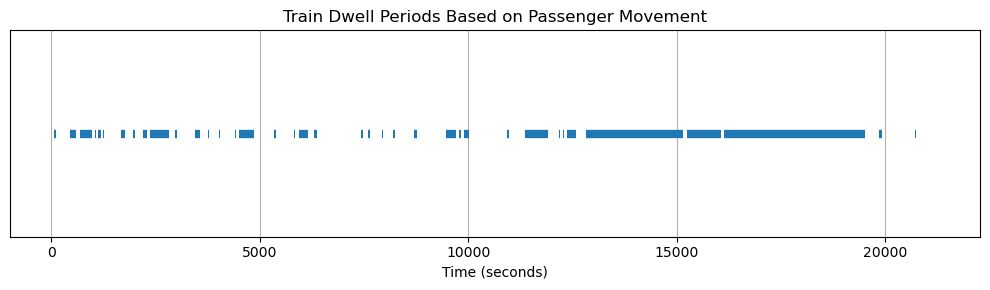

In [17]:
plt.figure(figsize=(10, 3))
for _, row in dwell_df.iterrows():
    plt.hlines(1, row['start_second'], row['end_second'], linewidth=6)
plt.xlabel("Time (seconds)")
plt.title("Train Dwell Periods Based on Passenger Movement")
plt.yticks([])
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Detect crossings
boarding_alighting_df = detect_boarding_alighting_times(agg_df, top_line_y, bottom_line_y)

# Focus only on 'top' door
door_df = boarding_alighting_df[boarding_alighting_df['entry_line'] == 'top'].copy()


In [19]:
def extract_main_train_event(door_df, max_gap=10):
    """
    Extracts the most significant train event (cluster of crossings) at a platform edge.

    Returns:
        event_df: passenger crossings for selected train event
        event_range: (start_second, end_second)
    """
    door_df = door_df.sort_values('second')
    seconds = door_df['second'].unique()
    seconds.sort()

    clusters = []
    current_cluster = [seconds[0]]
    prev = seconds[0]

    for sec in seconds[1:]:
        if sec - prev <= max_gap:
            current_cluster.append(sec)
        else:
            clusters.append(current_cluster)
            current_cluster = [sec]
        prev = sec

    if current_cluster:
        clusters.append(current_cluster)

    # Get the cluster with most people
    best_cluster = None
    max_ids = 0
    for cluster in clusters:
        ids = door_df[door_df['second'].isin(cluster)]['id'].nunique()
        if ids > max_ids:
            max_ids = ids
            best_cluster = cluster

    event_df = door_df[door_df['second'].isin(best_cluster)].copy()
    event_range = (min(best_cluster), max(best_cluster))

    return event_df, event_range


In [20]:
event_df, (start_sec, end_sec) = extract_main_train_event(door_df)
print(f" Selected event between {start_sec}s and {end_sec}s with {event_df['id'].nunique()} passengers.")


 Selected event between 17142s and 17231s with 35 passengers.


In [21]:
def visualize_train_event(event_df, agg_df, start_sec, end_sec):
    """
    Visualizes passenger trajectories during a specific train event window.
    """
    ids = event_df['id'].unique()
    traj_df = agg_df[(agg_df['id'].isin(ids)) & (agg_df['second'].between(start_sec - 5, end_sec + 5))]

    plt.figure(figsize=(10, 6))
    for pid, group in traj_df.groupby('id'):
        plt.plot(group['x'], group['y'], alpha=0.5)

    # Measurement line
    plt.axhline(top_line_y, color='blue', linestyle='--', label='Measurement Line (Top)')

    plt.title(f"Passenger Trajectories during Train Event ({start_sec}s to {end_sec}s)")
    plt.xlabel("x position (meters)")
    plt.ylabel("y position (meters)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

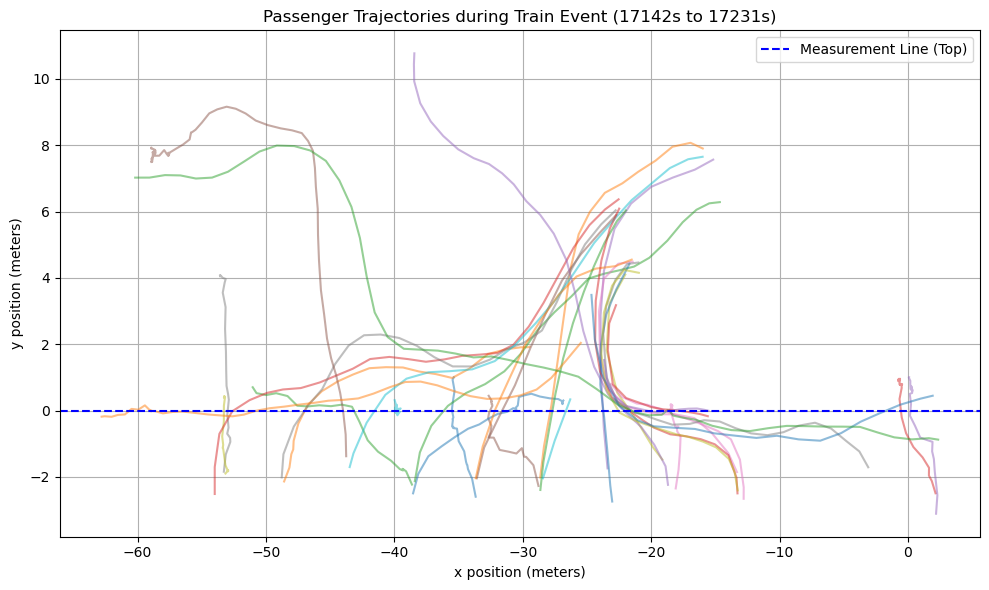

In [22]:
visualize_train_event(event_df, agg_df, start_sec, end_sec)

In [23]:
event_df  # DataFrame with columns ['id', 'second', 'entry_line', 'direction']

,id,second,entry_line,direction
394,9018758,17142,top,alighting
460,9019349,17143,top,alighting
444,9019259,17146,top,alighting
458,9019335,17146,top,alighting
404,9018853,17148,top,alighting
453,9019284,17150,top,alighting
421,9019133,17151,top,alighting
422,9019137,17151,top,alighting
466,9019369,17152,top,alighting
399,9018816,17153,top,alighting


This function counts the number of unique passengers who boarded, alighted, or did either during a specific train event.



In [24]:
def count_boarding_alighting(event_df):
    """
    Count number of unique passengers boarding and alighting during the train event.

    Returns:
        Dictionary with counts
    """
    boarding_ids = event_df[event_df['direction'] == 'boarding']['id'].unique()
    alighting_ids = event_df[event_df['direction'] == 'alighting']['id'].unique()

    return {
        'boarding_count': len(boarding_ids),
        'alighting_count': len(alighting_ids),
        'total_unique_passengers': len(np.unique(np.concatenate([boarding_ids, alighting_ids])))
    }


In [25]:
counts = count_boarding_alighting(event_df)

print(f" Passengers boarding: {counts['boarding_count']}")
print(f" Passengers alighting: {counts['alighting_count']}")
print(f"Total unique passengers involved: {counts['total_unique_passengers']}")

 Passengers boarding: 23
 Passengers alighting: 17
Total unique passengers involved: 35


In [26]:
def plot_labeled_boarding_alighting(event_df, agg_df, start_sec, end_sec):
    """
    Plot passenger trajectories with labels for boarding and alighting during a train event.
    """
    ids = event_df['id'].unique()
    traj_df = agg_df[(agg_df['id'].isin(ids)) & (agg_df['second'].between(start_sec - 5, end_sec + 5))]

    plt.figure(figsize=(12, 6))
    
    for pid, group in traj_df.groupby('id'):
        direction = event_df[event_df['id'] == pid]['direction'].iloc[0]
        color = 'green' if direction == 'boarding' else 'red'
        label = 'Boarding' if direction == 'boarding' else 'Alighting'
        plt.plot(group['x'], group['y'], color=color, alpha=0.6)
        plt.text(group['x'].iloc[-1], group['y'].iloc[-1], f"{pid}", fontsize=8, color=color)

    # Draw measurement line (top edge)
    plt.axhline(top_line_y, color='blue', linestyle='--', label='Measurement Line (Top)')

    plt.title(f"Boarding and Alighting Passengers ({start_sec}s to {end_sec}s)")
    plt.xlabel("x (meters)")
    plt.ylabel("y (meters)")
    plt.grid(True)
    plt.legend(handles=[
        plt.Line2D([0], [0], color='green', lw=2, label='Boarding'),
        plt.Line2D([0], [0], color='red', lw=2, label='Alighting'),
        plt.Line2D([0], [0], color='blue', linestyle='--', label='Measurement Line')
    ])
    plt.tight_layout()
    plt.show()


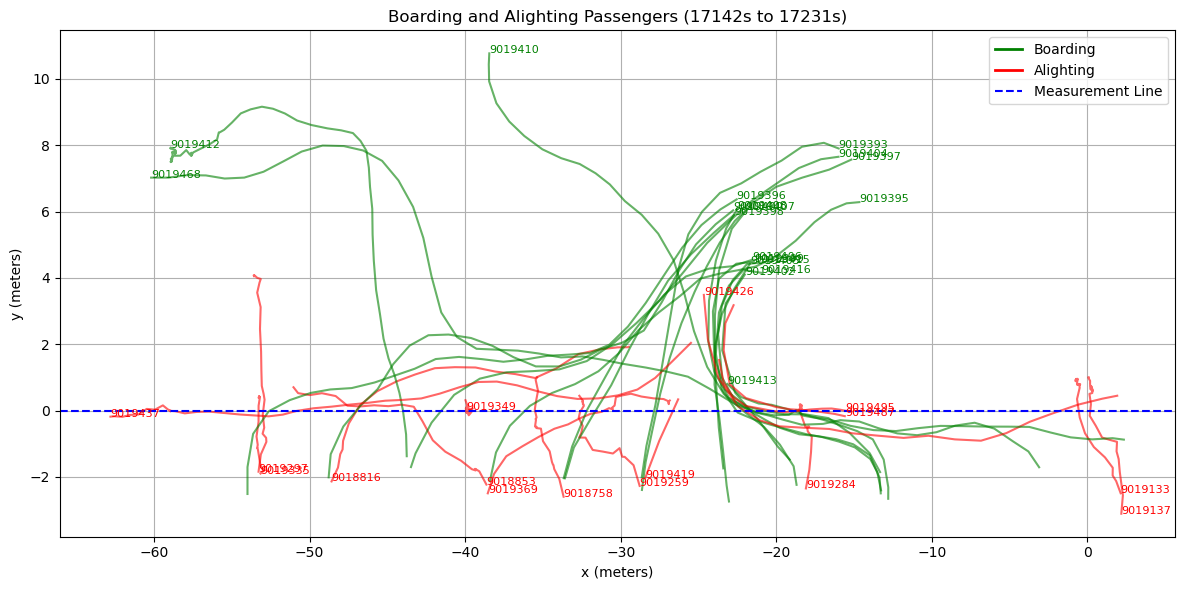

In [27]:
plot_labeled_boarding_alighting(event_df, agg_df, start_sec, end_sec)

This function identifies multiple train stop events from a dataset of passenger crossing times at a door (e.g., top or bottom edge of a train platform), based on clusters of activity.

It returns a summary table of these events, showing when each event started and ended, how long it lasted, and how many passengers boarded or alighted.

In [28]:
def extract_all_train_events(door_df, max_gap=10, min_cluster_size=5):
    """
    Extracts multiple train events from the full dataset based on passenger crossing clusters.
    Returns a list of dictionaries: [{'start': ..., 'end': ..., 'boarding': ..., 'alighting': ..., 'duration': ...}]
    """
    door_df = door_df.sort_values('second')
    seconds = door_df['second'].unique()
    seconds.sort()

    clusters = []
    current = [seconds[0]]
    prev = seconds[0]

    for sec in seconds[1:]:
        if sec - prev <= max_gap:
            current.append(sec)
        else:
            if len(current) >= 2:
                clusters.append(current)
            current = [sec]
        prev = sec
    if len(current) >= 2:
        clusters.append(current)

    events = []
    for cluster in clusters:
        start, end = min(cluster), max(cluster)
        subset = door_df[door_df['second'].between(start, end)]
        if subset['id'].nunique() < min_cluster_size:
            continue

        boarding = subset[subset['direction'] == 'boarding']['id'].nunique()
        alighting = subset[subset['direction'] == 'alighting']['id'].nunique()
        duration = end - start + 1

        events.append({
            'start': start,
            'end': end,
            'duration': duration,
            'boarding': boarding,
            'alighting': alighting
        })

    return pd.DataFrame(events)


The function fits a linear regression model to predict dwell time (duration a vehicle stays at a stop) based on two variables:

boarding: number of passengers boarding

alighting: number of passengers alighting

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fit_boarding_alighting_model(events_df):
    """
    Fits a linear model: dwell_time = a * boarding + b * alighting + c
    Returns the fitted model, the equation, and the R² score.
    """
    X = events_df[['boarding', 'alighting']]
    y = events_df['duration']
    
    model = LinearRegression().fit(X, y)
    a, b = model.coef_
    c = model.intercept_

    # Predict on training data
    y_pred = model.predict(X)
    accuracy = r2_score(y, y_pred)

    print(f"Dwell Time Model: dwell_time = {a:.2f} * boarding + {b:.2f} * alighting + {c:.2f}")
    print(f"Model R² score: {accuracy:.4f}")

    return model, lambda board, alight: a * board + b * alight + c, accuracy





a=2.29, it means each additional boarding passenger adds 2.29 seconds to the dwell time, all else equal.
b=1.91, each alighting passenger adds 1.91 seconds.
c 15.95 seconds — meaning even with zero passengers boarding or alighting, the train typically spends 15.95 seconds at the stop.



In [30]:
# Step 1: Detect crossings and filter to 'top' door
boarding_alighting_df = detect_boarding_alighting_times(agg_df, top_line_y, bottom_line_y)
door_df = boarding_alighting_df[boarding_alighting_df['entry_line'] == 'top'].copy()

# Step 2: Extract all train events
events_df = extract_all_train_events(door_df)

# Step 3: Fit the model
model, dwell_time_fn,accuracy = fit_boarding_alighting_model(events_df)

#  Example prediction
print("\n Example: 12 boarding, 8 alighting => Estimated dwell time:")
print(f"{dwell_time_fn(12, 8):.2f} seconds")


Dwell Time Model: dwell_time = 2.29 * boarding + 1.91 * alighting + 15.95
Model R² score: 0.4107

 Example: 12 boarding, 8 alighting => Estimated dwell time:
58.72 seconds


In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fit_poly_boarding_alighting_model(events_df, degree=2):
    X = events_df[['boarding', 'alighting']]
    y = events_df['duration']

    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_poly)
    accuracy = r2_score(y, y_pred)

    coefs = model.coef_
    intercept = model.intercept_

    # Get feature names like ['1', 'boarding', 'alighting', 'boarding^2', 'boarding alighting', 'alighting^2']
    feature_names = poly.get_feature_names_out(input_features=['boarding', 'alighting'])

    print(f"Polynomial Degree: {degree}")
    print(f"Model R² score: {accuracy:.4f}")
    print(f"Intercept: {intercept:.4f}")

    # Build equation string
    equation_terms = [f"{intercept:.4f}"]
    for coef, name in zip(coefs[1:], feature_names[1:]):  # skip intercept term at index 0
        sign = "+" if coef >= 0 else "-"
        equation_terms.append(f" {sign} {abs(coef):.4f}*{name}")

    equation = "dwell_time = " + "".join(equation_terms)
    print("Polynomial dwell time model equation:")
    print(equation)

    return model, poly, accuracy

# Usage:
model, poly, accuracy = fit_poly_boarding_alighting_model(events_df)

# To predict:
def dwell_time_fn(board, alight):
    x = poly.transform([[board, alight]])
    return model.predict(x)[0]

print(f"\nEstimated dwell time for 12 boarding, 8 alighting: {dwell_time_fn(12, 8):.2f} seconds")


Polynomial Degree: 2
Model R² score: 0.5182
Intercept: 4.8377
Polynomial dwell time model equation:
dwell_time = 4.8377 + 3.8978*boarding + 3.8265*alighting - 0.2462*boarding^2 + 0.2234*boarding alighting - 0.1361*alighting^2

Estimated dwell time for 12 boarding, 8 alighting: 59.50 seconds


C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

# Prepare data
X = events_df[['boarding', 'alighting']]
y = events_df['duration']

# Train/test split to evaluate generalization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
test_r2 = r2_score(y_test, y_pred)

print(f"Best RF params: {grid_search.best_params_}")
print(f"Test R² score: {test_r2:.4f}")

# Example prediction function
def dwell_time_rf(board, alight):
    return best_rf.predict([[board, alight]])[0]

print(f"Estimated dwell time for 12 boarding, 8 alighting: {dwell_time_rf(12, 8):.2f} seconds")


Best RF params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
Test R² score: 0.1098
Estimated dwell time for 12 boarding, 8 alighting: 64.70 seconds


C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [38]:
from sklearn.metrics import r2_score
import pandas as pd

# 1. Predict dwell time using your polynomial model
events_df = events_df.copy()
events_df['Predicted Dwell Time (s)'] = events_df.apply(
    lambda row: dwell_time_fn(row['boarding'], row['alighting']),
    axis=1
)

# 2. Compute R² between actual and predicted
r2 = r2_score(events_df['duration'], events_df['Predicted Dwell Time (s)'])

# 3. Create results table with actual, predicted, and R²
results_table = events_df[['boarding', 'alighting', 'duration', 'Predicted Dwell Time (s)']].copy()
results_table.rename(columns={
    'boarding': 'Boarding Passengers',
    'alighting': 'Alighting Passengers',
    'duration': 'Actual Dwell Time (s)'
}, inplace=True)

results_table['R²'] = round(r2, 2)

# 4. Display the first few rows
results_table

C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
C:\Users\hp\Documents\ANA\Lib\site-packages\sklearn\base.py:493: UserWarnin

,Boarding Passengers,Alighting Passengers,Actual Dwell Time (s),Predicted Dwell Time (s),R²
0,12,1,31,22.523016,0.52
1,6,6,46,45.463050,0.52
2,8,6,65,49.044836,0.52
3,6,5,46,41.792808,0.52
4,0,22,41,23.161229,0.52
5,6,4,28,37.850423,0.52
6,6,2,25,29.149226,0.52
7,13,21,101,95.237154,0.52
8,0,5,13,20.568203,0.52
9,9,2,42,31.102028,0.52
